In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adhoppin/blood-cell-detection-datatset

 68% 8.00M/11.8M [00:00<00:00, 81.2MB/s]
100% 11.8M/11.8M [00:00<00:00, 97.0MB/s]


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [ ]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [ ]:
! unzip /content/blood-cell-detection-datatset.zip -d '/content'

Archive:  /content/blood-cell-detection-datatset.zip
  inflating: /content/LICENSE        
  inflating: /content/README.dataset.txt  
  inflating: /content/README.md      
  inflating: /content/data.yaml      
  inflating: /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
  inflating: /content/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
  inflating: /content/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
  inflating: /content/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
  inflating: /content/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
  inflating: /content/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg  
  inflating: /content/test/images/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg  
  inflating: /content/test/images/BloodImage_00120_jpg.rf.6725d54bf5615683448eb1de4c7577ee.jpg  
  inflating: /

In [ ]:
!cat ../content/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [ ]:
ls -1 ../content/train/images | wc -l

765


In [ ]:
# Load the YAML file
with open('../content/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data. You must use absolute path, relative path won't work
data_yaml['train'] = '/content/train/images'
data_yaml['val'] = '/content/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
data_dir = Path("../content/")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [ ]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


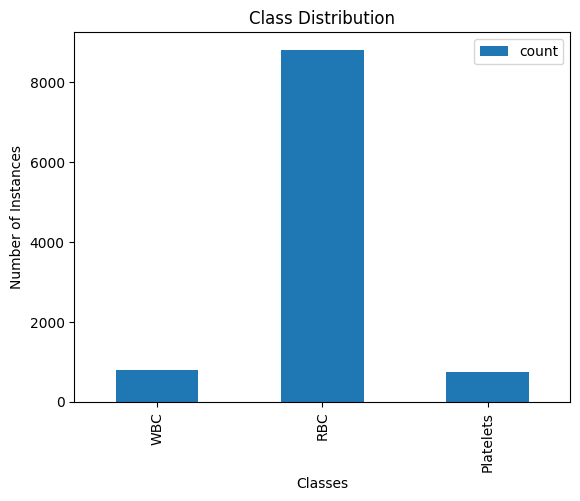

In [ ]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))

        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])
df.head(5)

,file,num_lines,unique_values
0,../content/train/labels/BloodImage_00001_jpg.r...,19,2
1,../content/train/labels/BloodImage_00001_jpg.r...,19,2
2,../content/train/labels/BloodImage_00001_jpg.r...,19,2
3,../content/train/labels/BloodImage_00002_jpg.r...,16,2
4,../content/train/labels/BloodImage_00002_jpg.r...,16,2


<Axes: >

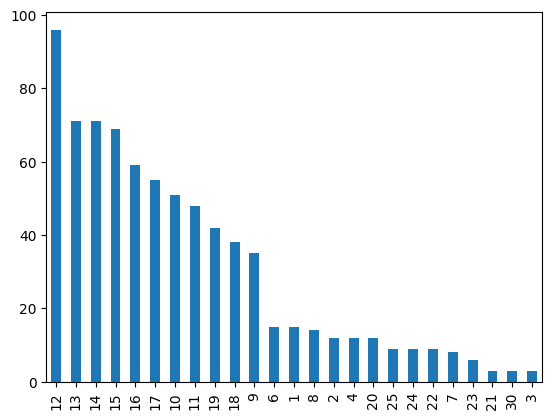

In [ ]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<Axes: >

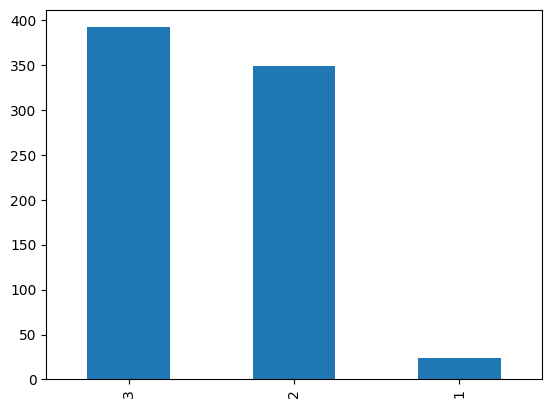

In [ ]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

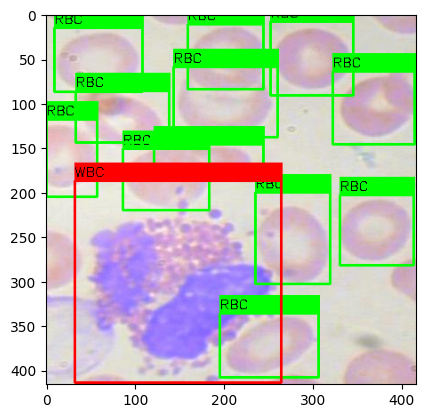

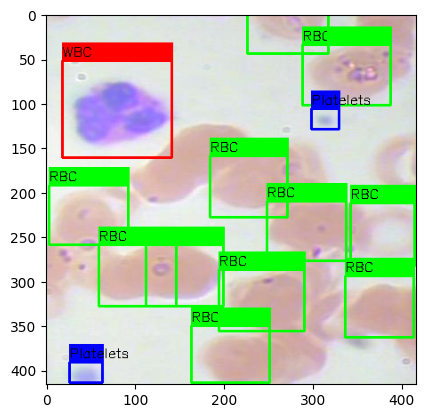

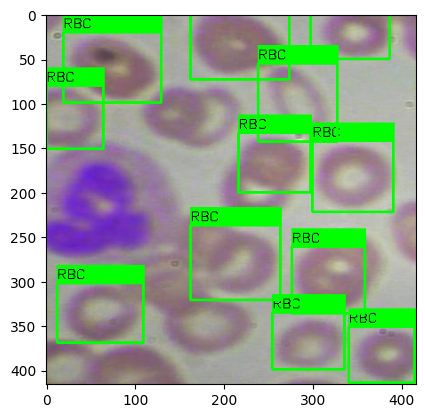

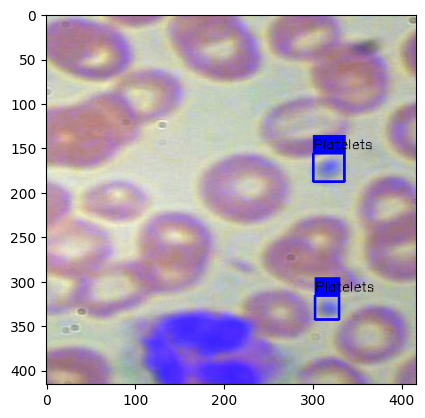

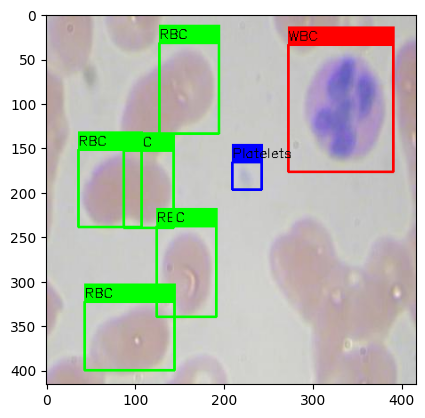

In [ ]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [ ]:
baseline_model = YOLO('yolov8x.pt')

# baseline_model = YOLO('yolov8x.pt', 'data.yaml')

100%|██████████| 131M/131M [00:00<00:00, 358MB/s]


In [ ]:
!yolo train model=yolov8x.pt data=data.yaml epochs=30 imgsz=640

Ultralytics YOLOv8.0.218 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False,

In [ ]:
# params = {
#     'data':'data.yaml',
#     'imgsz':416,
#     'epochs':25,
#     'optimizer':'Adam',
#     'pretrained':True,
#     'lr0':0.1,
#     'lrf': 0.00001,
#     'cos_lr': True
# }

In [ ]:
# load a pretrained model (recommended for training)
model = YOLO('yolov8x.pt')

# Use the model
results = model.train(data='data.yaml', epochs=30, batch = 8)

100%|██████████| 131M/131M [00:01<00:00, 103MB/s] 


Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=30, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False

100%|██████████| 755k/755k [00:00<00:00, 14.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 71.6MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 2018.58it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1388.66it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.32G      1.345      1.367      1.529         66        640: 100%|██████████| 96/96 [01:02<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]

                   all         73        967      0.639      0.826      0.802      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.87G       1.29      1.071       1.45         96        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all         73        967      0.664      0.738      0.718      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.93G      1.292      1.038      1.443        109        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all         73        967      0.795      0.869      0.888      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.95G      1.273      1.006       1.43         54        640: 100%|██████████| 96/96 [01:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.10it/s]

                   all         73        967      0.788      0.905      0.894       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.97G      1.244     0.9794      1.397        113        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]

                   all         73        967      0.798      0.869      0.889      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.95G      1.254     0.9505      1.409         68        640: 100%|██████████| 96/96 [00:59<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all         73        967      0.787      0.865      0.902       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.88G      1.218     0.9433      1.409        103        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]

                   all         73        967      0.787      0.834      0.875      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.97G       1.19     0.8833      1.369        125        640: 100%|██████████| 96/96 [00:59<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all         73        967      0.763      0.918      0.878      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.96G      1.192     0.8891      1.382         74        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all         73        967      0.825        0.9      0.898      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.98G      1.165     0.8573      1.341        139        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all         73        967      0.808      0.914      0.895      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      8.02G      1.163     0.8362      1.349         84        640: 100%|██████████| 96/96 [00:59<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]

                   all         73        967      0.817      0.909      0.908       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.98G      1.158     0.8395       1.34         90        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

                   all         73        967      0.829      0.893       0.91      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.97G      1.156      0.838       1.33        112        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all         73        967      0.849       0.91      0.922      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.96G      1.177     0.8378      1.348        115        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all         73        967      0.811      0.921      0.894      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.96G      1.135     0.8046       1.32         80        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

                   all         73        967       0.84      0.886      0.897      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.95G      1.121     0.8099      1.314         97        640: 100%|██████████| 96/96 [00:59<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

                   all         73        967      0.825      0.866      0.891      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.99G      1.108     0.7852        1.3        121        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all         73        967      0.876      0.896      0.922      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.97G      1.108     0.7916      1.301         96        640: 100%|██████████| 96/96 [00:59<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all         73        967      0.825      0.899        0.9      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.98G      1.098     0.7684      1.297        122        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.17it/s]

                   all         73        967      0.822      0.897      0.914      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.92G      1.088     0.7646      1.284         95        640: 100%|██████████| 96/96 [00:59<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]

                   all         73        967       0.84      0.891      0.911      0.614


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.91G      1.104     0.7433      1.342         61        640: 100%|██████████| 96/96 [01:00<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all         73        967       0.82      0.912      0.913      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.92G      1.095      0.742      1.341         66        640: 100%|██████████| 96/96 [00:59<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

                   all         73        967       0.87      0.877      0.921      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.87G       1.07     0.7145      1.312         63        640: 100%|██████████| 96/96 [00:58<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all         73        967      0.814      0.909      0.912      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.89G      1.073     0.6958      1.309         73        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all         73        967      0.874      0.867      0.915      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.88G      1.067     0.6945      1.314         77        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.18it/s]

                   all         73        967      0.858      0.917      0.925      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       7.9G      1.053     0.6805      1.303         40        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all         73        967      0.839      0.908      0.925      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       7.9G      1.036     0.6735      1.295         61        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all         73        967      0.859      0.878      0.914      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.88G      1.028     0.6563      1.277         65        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

                   all         73        967      0.867      0.896      0.922      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.87G       1.02     0.6442      1.269         65        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all         73        967      0.843      0.908      0.918      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.91G      1.012     0.6409      1.268         80        640: 100%|██████████| 96/96 [00:58<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.20it/s]

                   all         73        967      0.871      0.903      0.928      0.651



30 epochs completed in 0.628 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.45s/it]


                   all         73        967      0.839      0.908      0.925      0.652
             Platelets         73         76       0.82      0.842      0.905      0.496
                   RBC         73        819      0.732      0.882      0.893      0.648
                   WBC         73         72      0.965          1      0.977      0.814
Speed: 2.5ms preprocess, 28.5ms inference, 0.0ms loss, 9.2ms postprocess per image
Results saved to runs/detect/train


In [ ]:
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68126457 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


                   all         73        967       0.84      0.907      0.925       0.65
             Platelets         73         76       0.82      0.839      0.905      0.495
                   RBC         73        819      0.733      0.882      0.893      0.648
                   WBC         73         72      0.965          1      0.977      0.808
Speed: 0.4ms preprocess, 74.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
from ultralytics.utils.metrics import ConfusionMatrix
from IPython.display import Image

In [ ]:
print(metrics.confusion_matrix.matrix)

[[         68           0           0          17]
 [          0         747           0         336]
 [          1           0          72           1]
 [          7          72           0           0]]


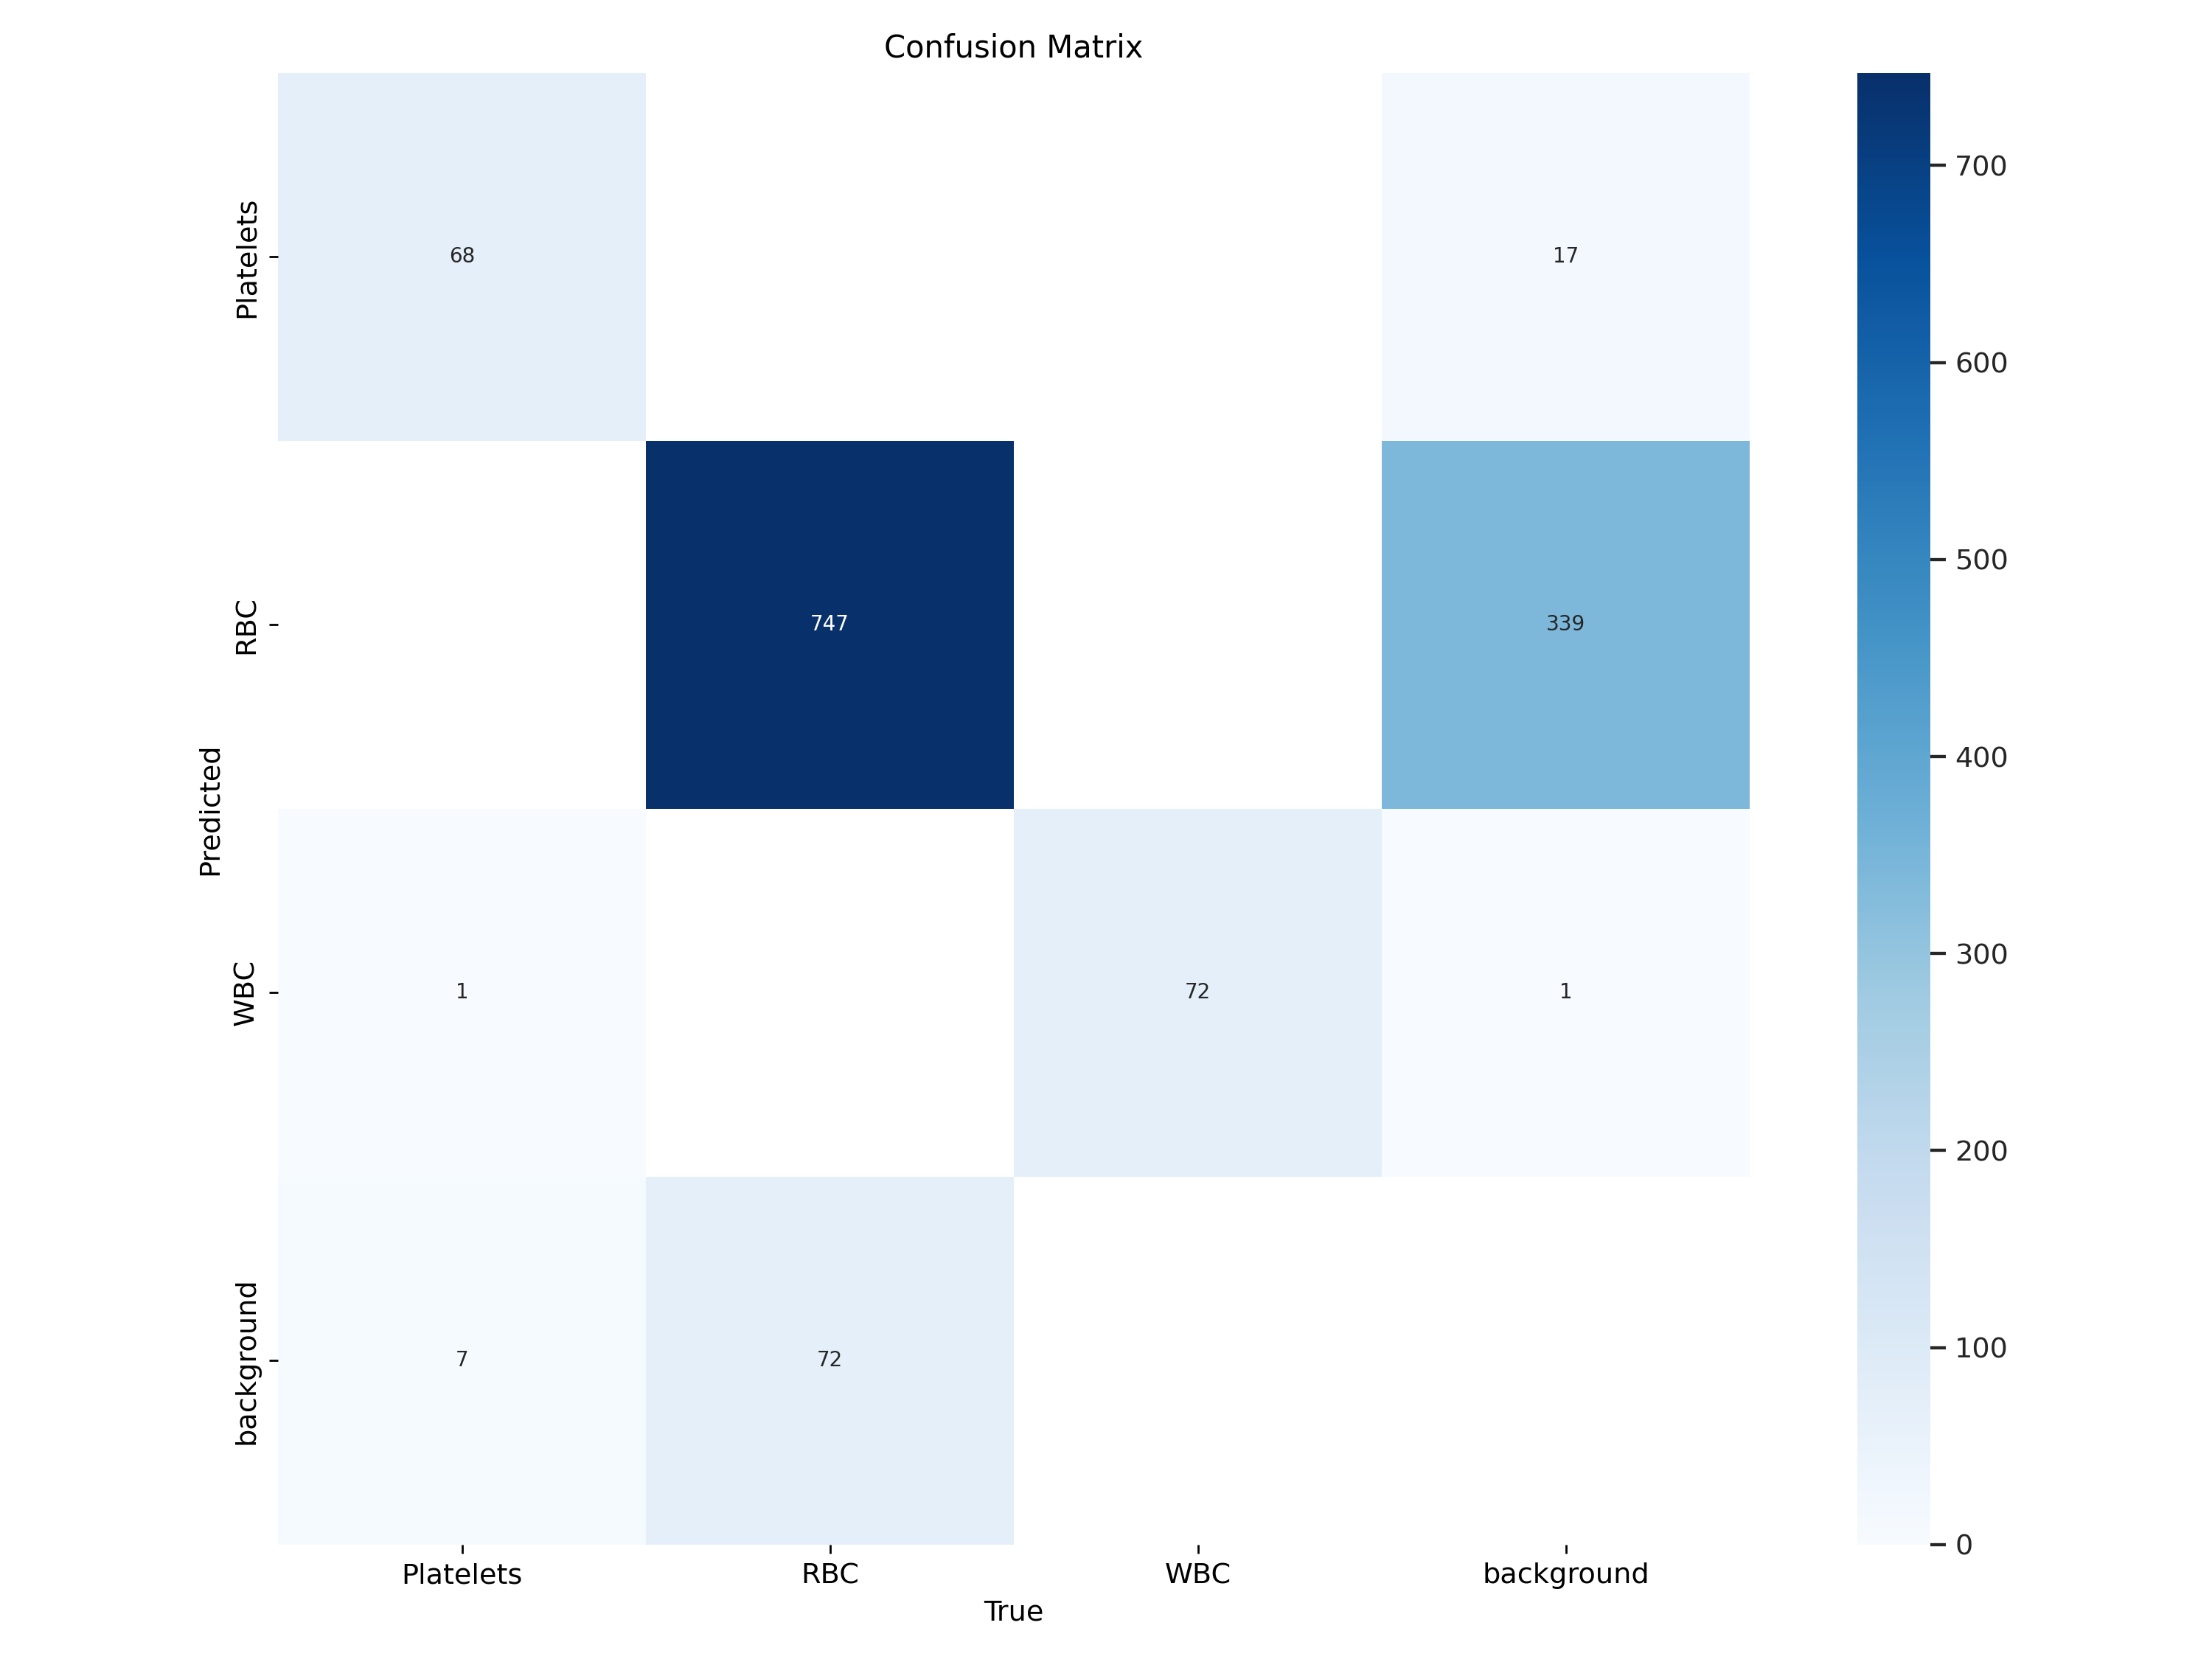

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', height=400)

In [ ]:
conf_mat = metrics.confusion_matrix.matrix

# Calculate IoU
iou = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat))

# Calculate Dice coefficient
dice_coefficient = (2 * np.diag(conf_mat)) / (conf_mat.sum(axis=0) + conf_mat.sum(axis=1))

print(f'Test IoU: {np.mean(iou):.4f}')
print(f'Test Dice Coefficient: {np.mean(dice_coefficient):.4f}')

Test IoU: 0.5877
Test Dice Coefficient: 0.6541


In [ ]:
print(metrics.box.map75)

0.7487829275506055


In [ ]:
print(metrics.box.f1)

[    0.82965     0.80064      0.9823]


In [ ]:
results = model('/content/train/images/BloodImage_00001_jpg.rf.1a3206b15602db1d97193162a50bd001.jpg')  # predict on an image


image 1/1 /content/train/images/BloodImage_00001_jpg.rf.1a3206b15602db1d97193162a50bd001.jpg: 640x640 20 RBCs, 1 WBC, 108.9ms
Speed: 5.0ms preprocess, 108.9ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


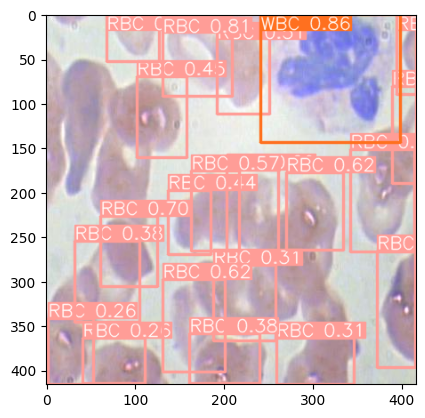

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.imshow(im)  # show image

GROUND TRUTH TRAINING DATA:


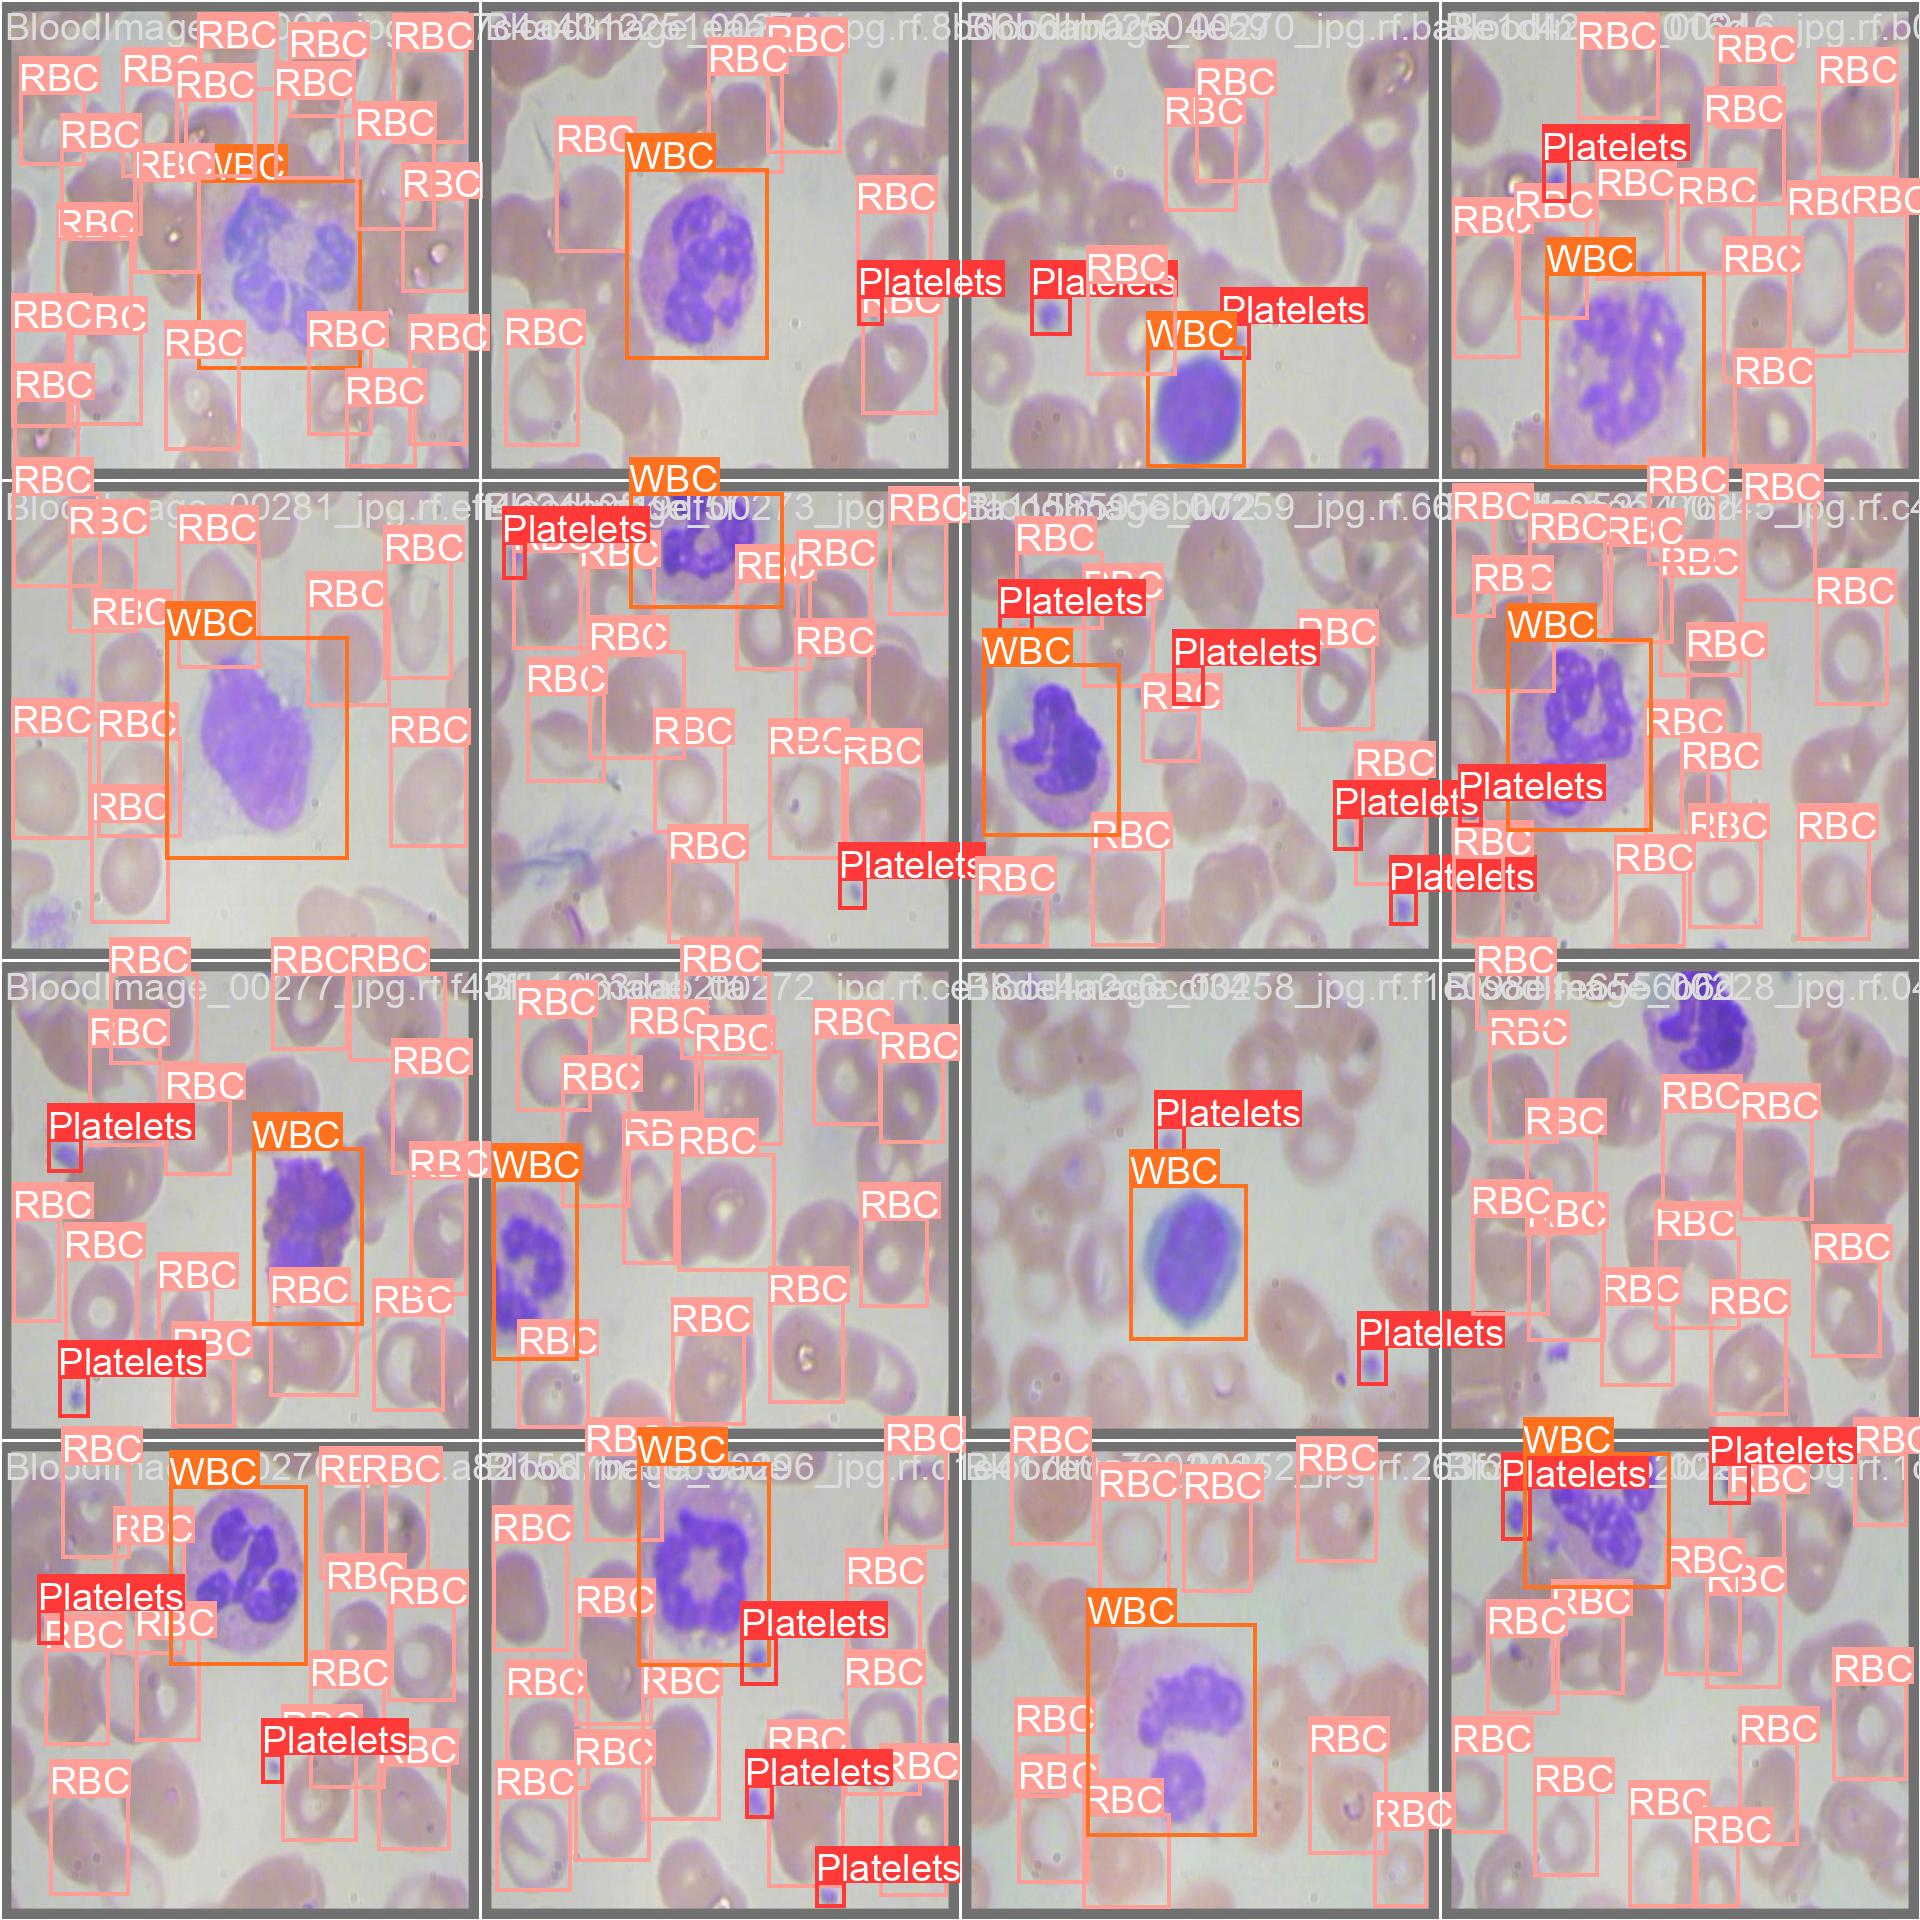

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/runs/detect/train/val_batch0_labels.jpg', width=900)

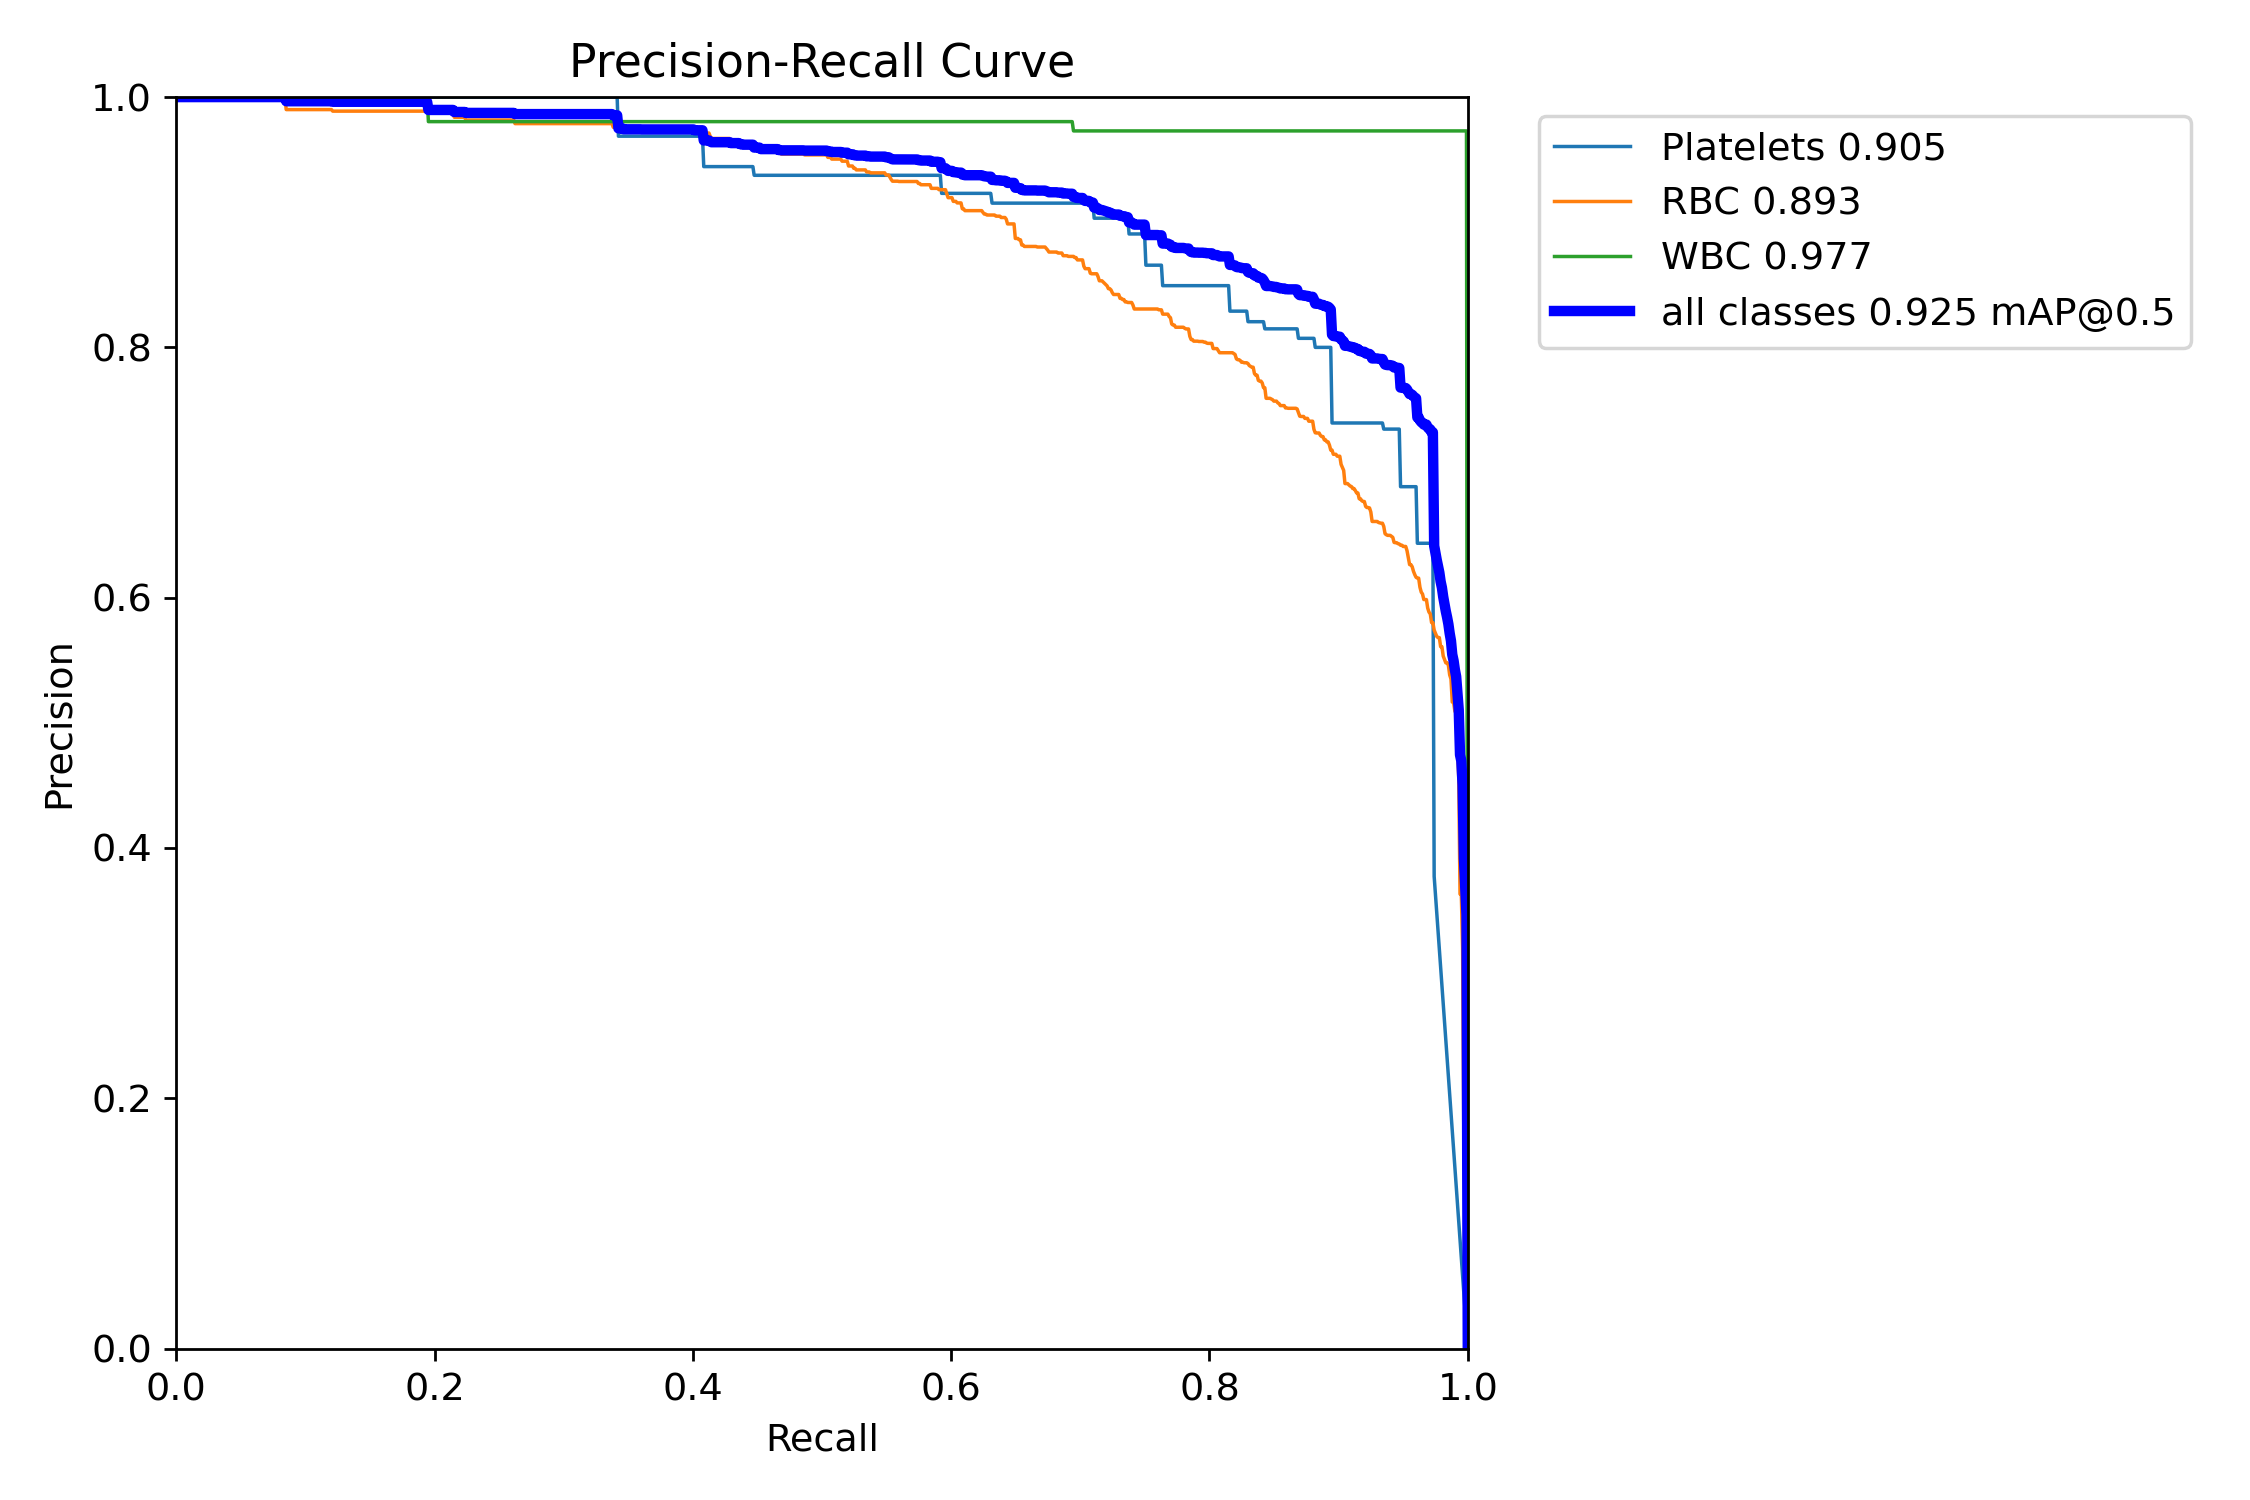

In [ ]:
Image(filename='/content/runs/detect/train/PR_curve.png', height=400)

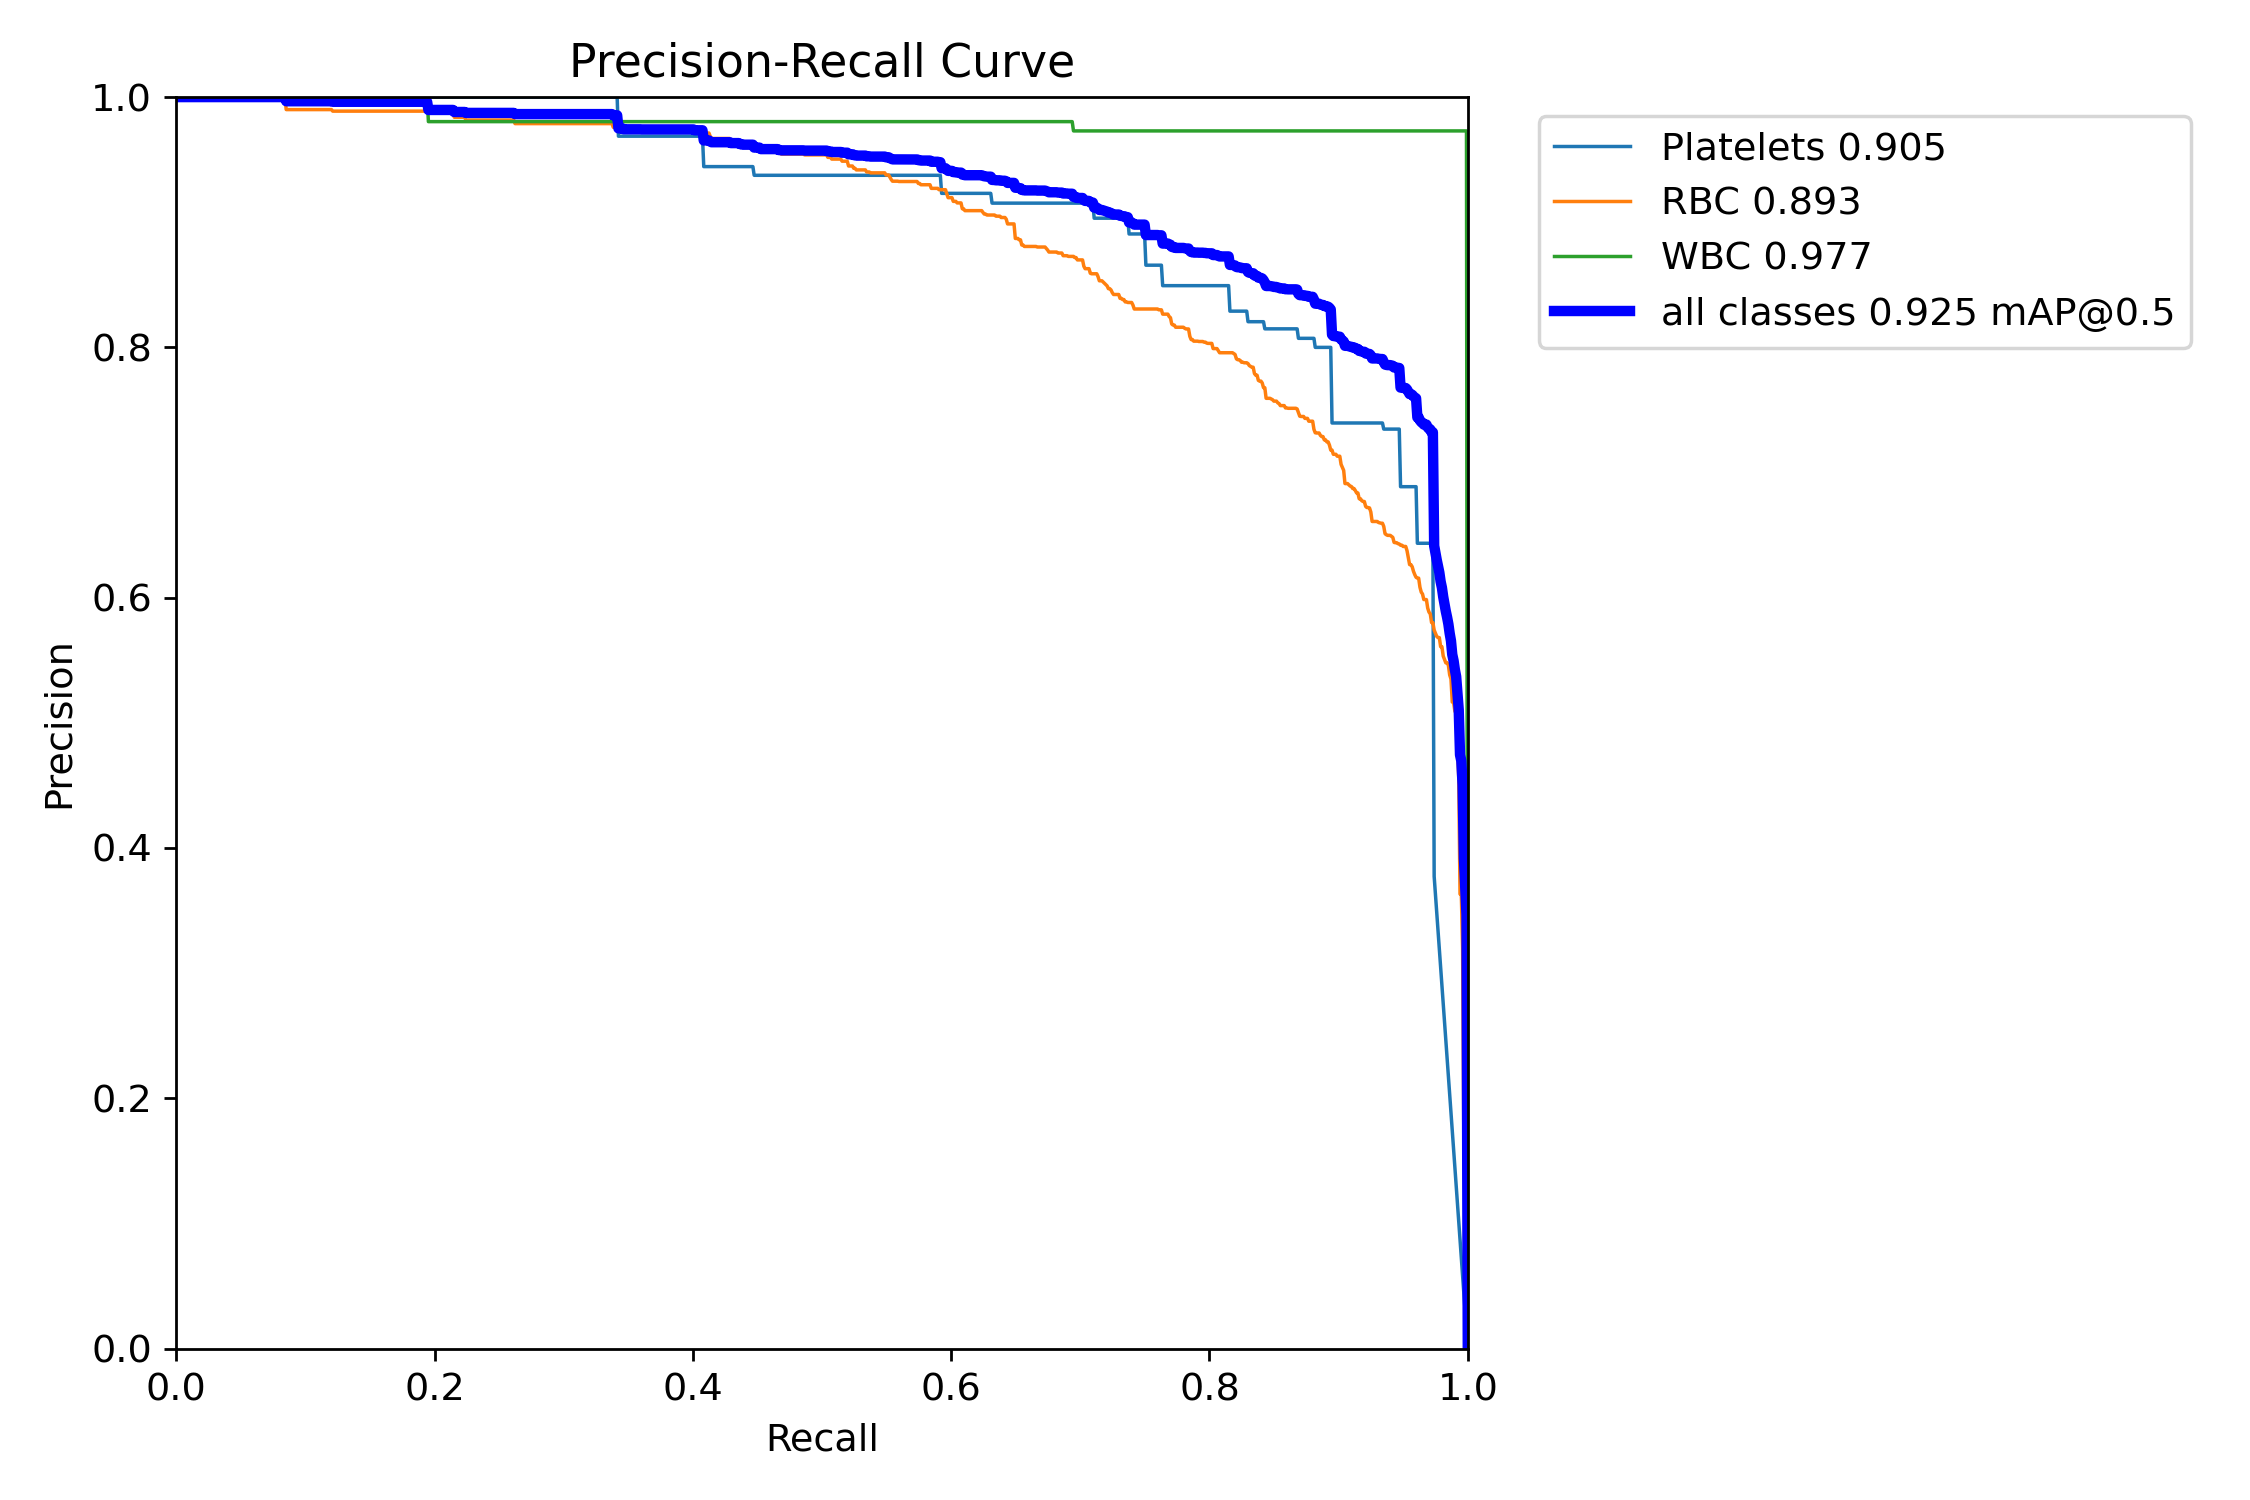

In [ ]:
Image(filename='/content/runs/detect/train/PR_curve.png', height=400)

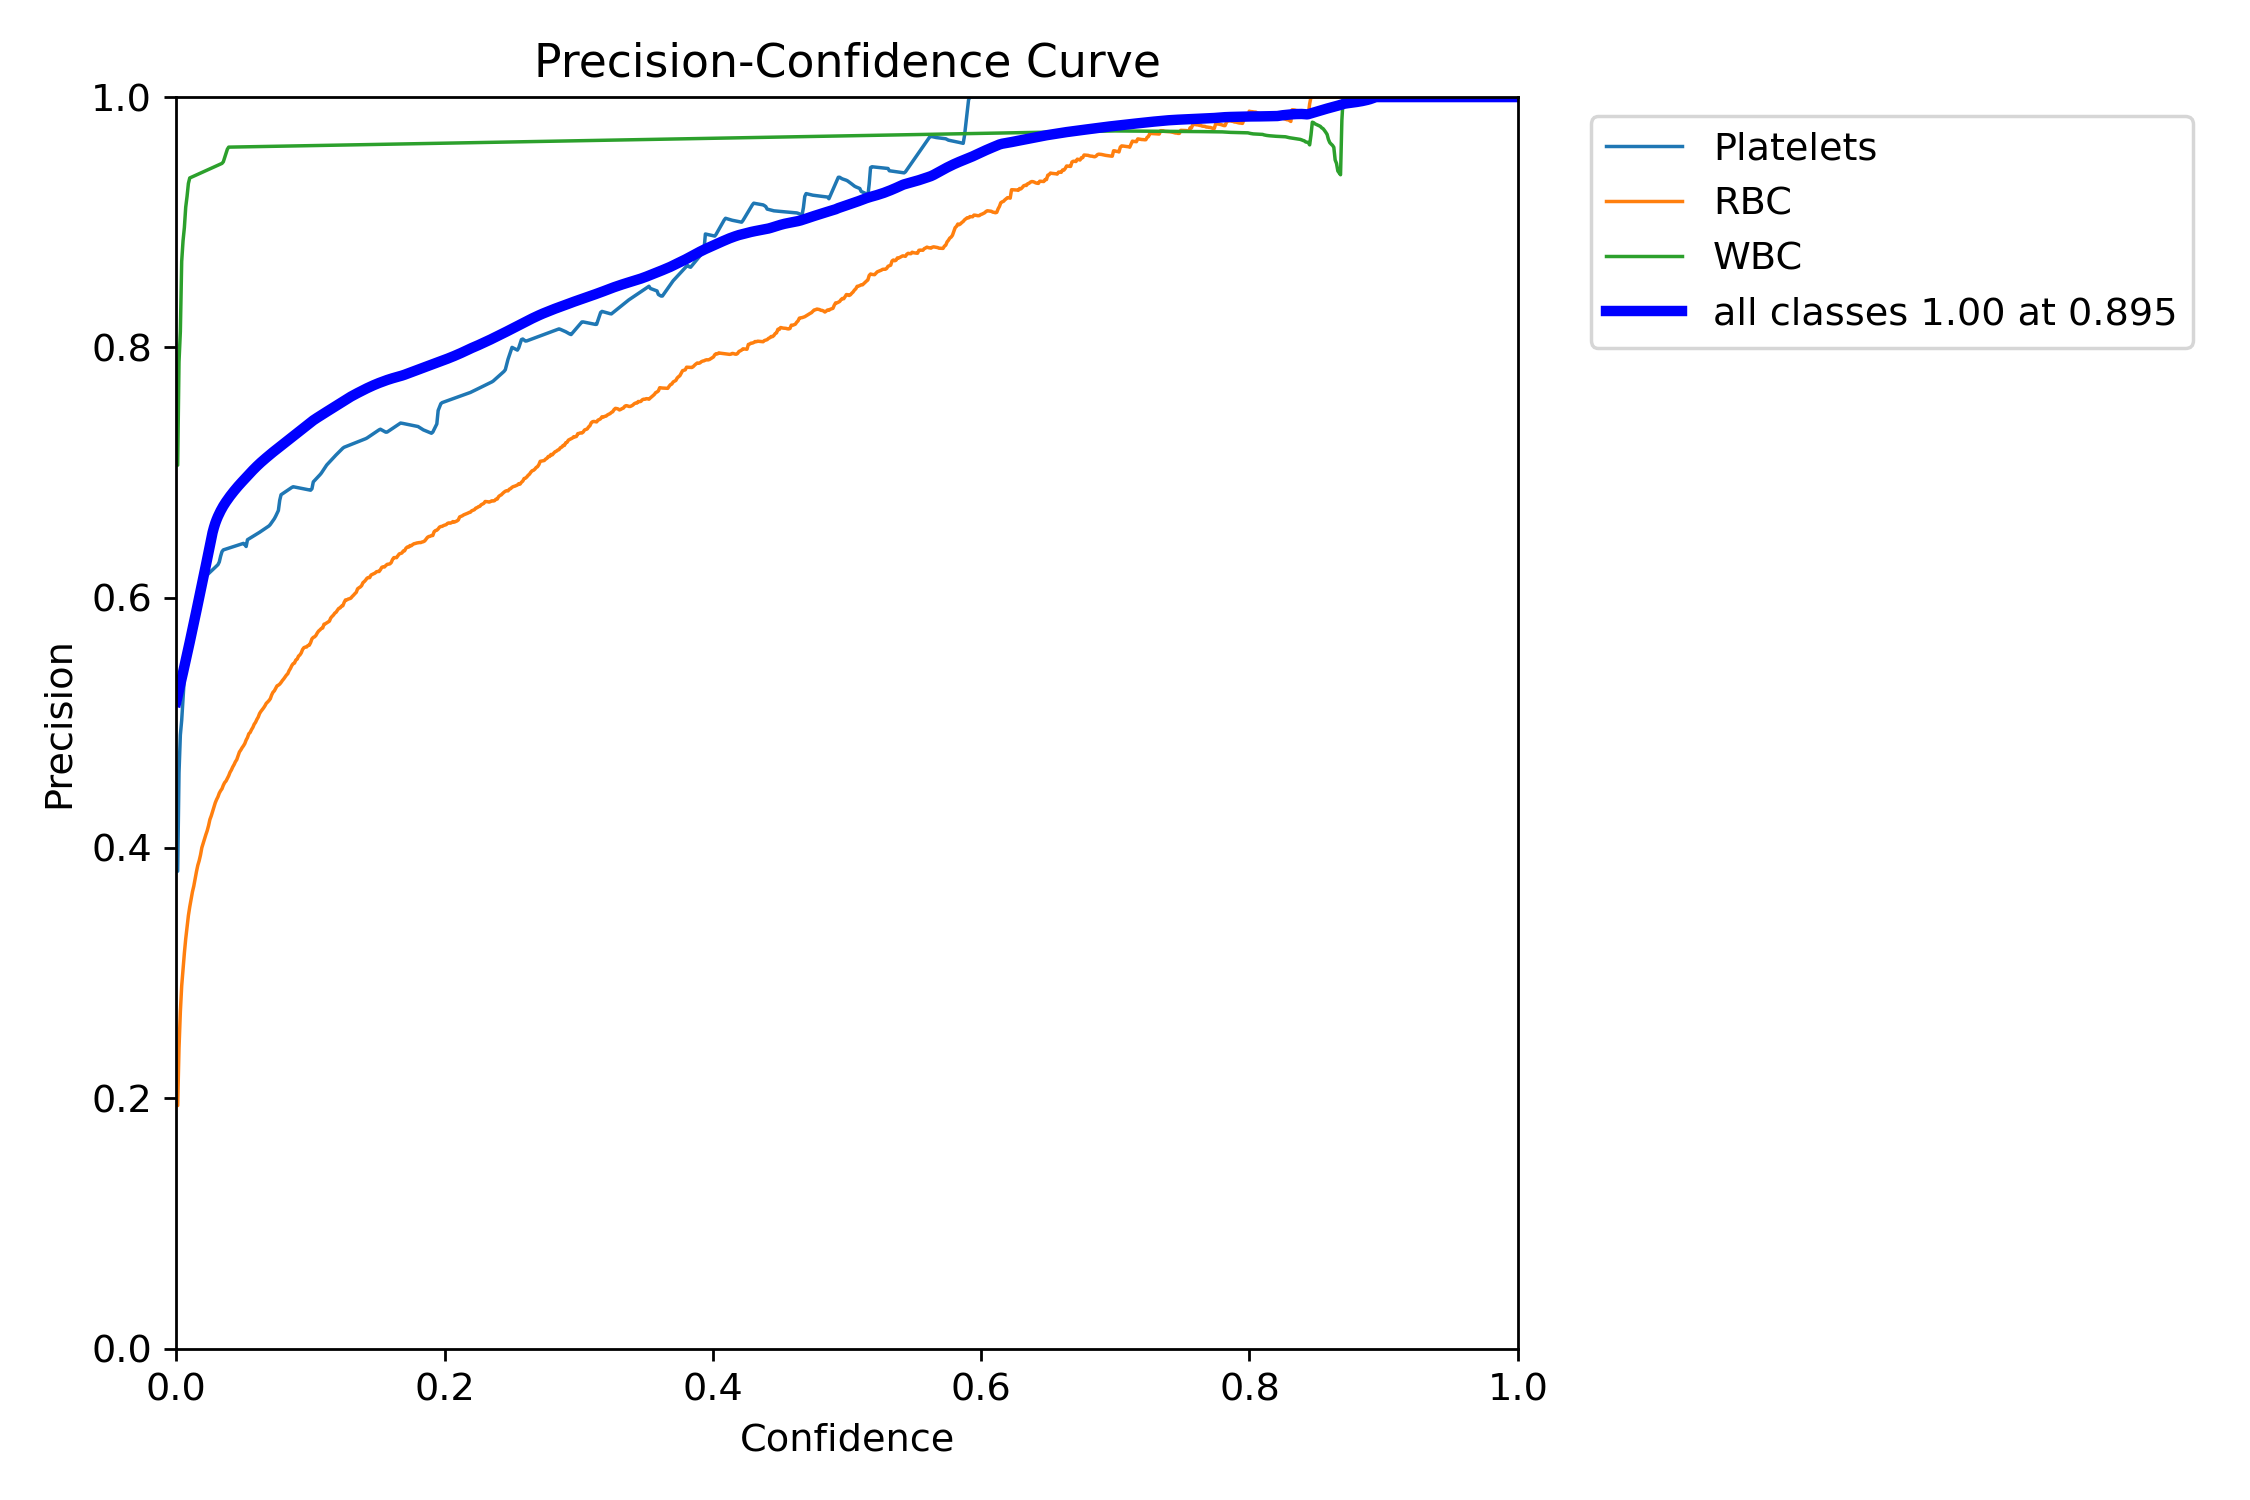

In [ ]:
Image(filename='/content/runs/detect/train/P_curve.png', height=400)

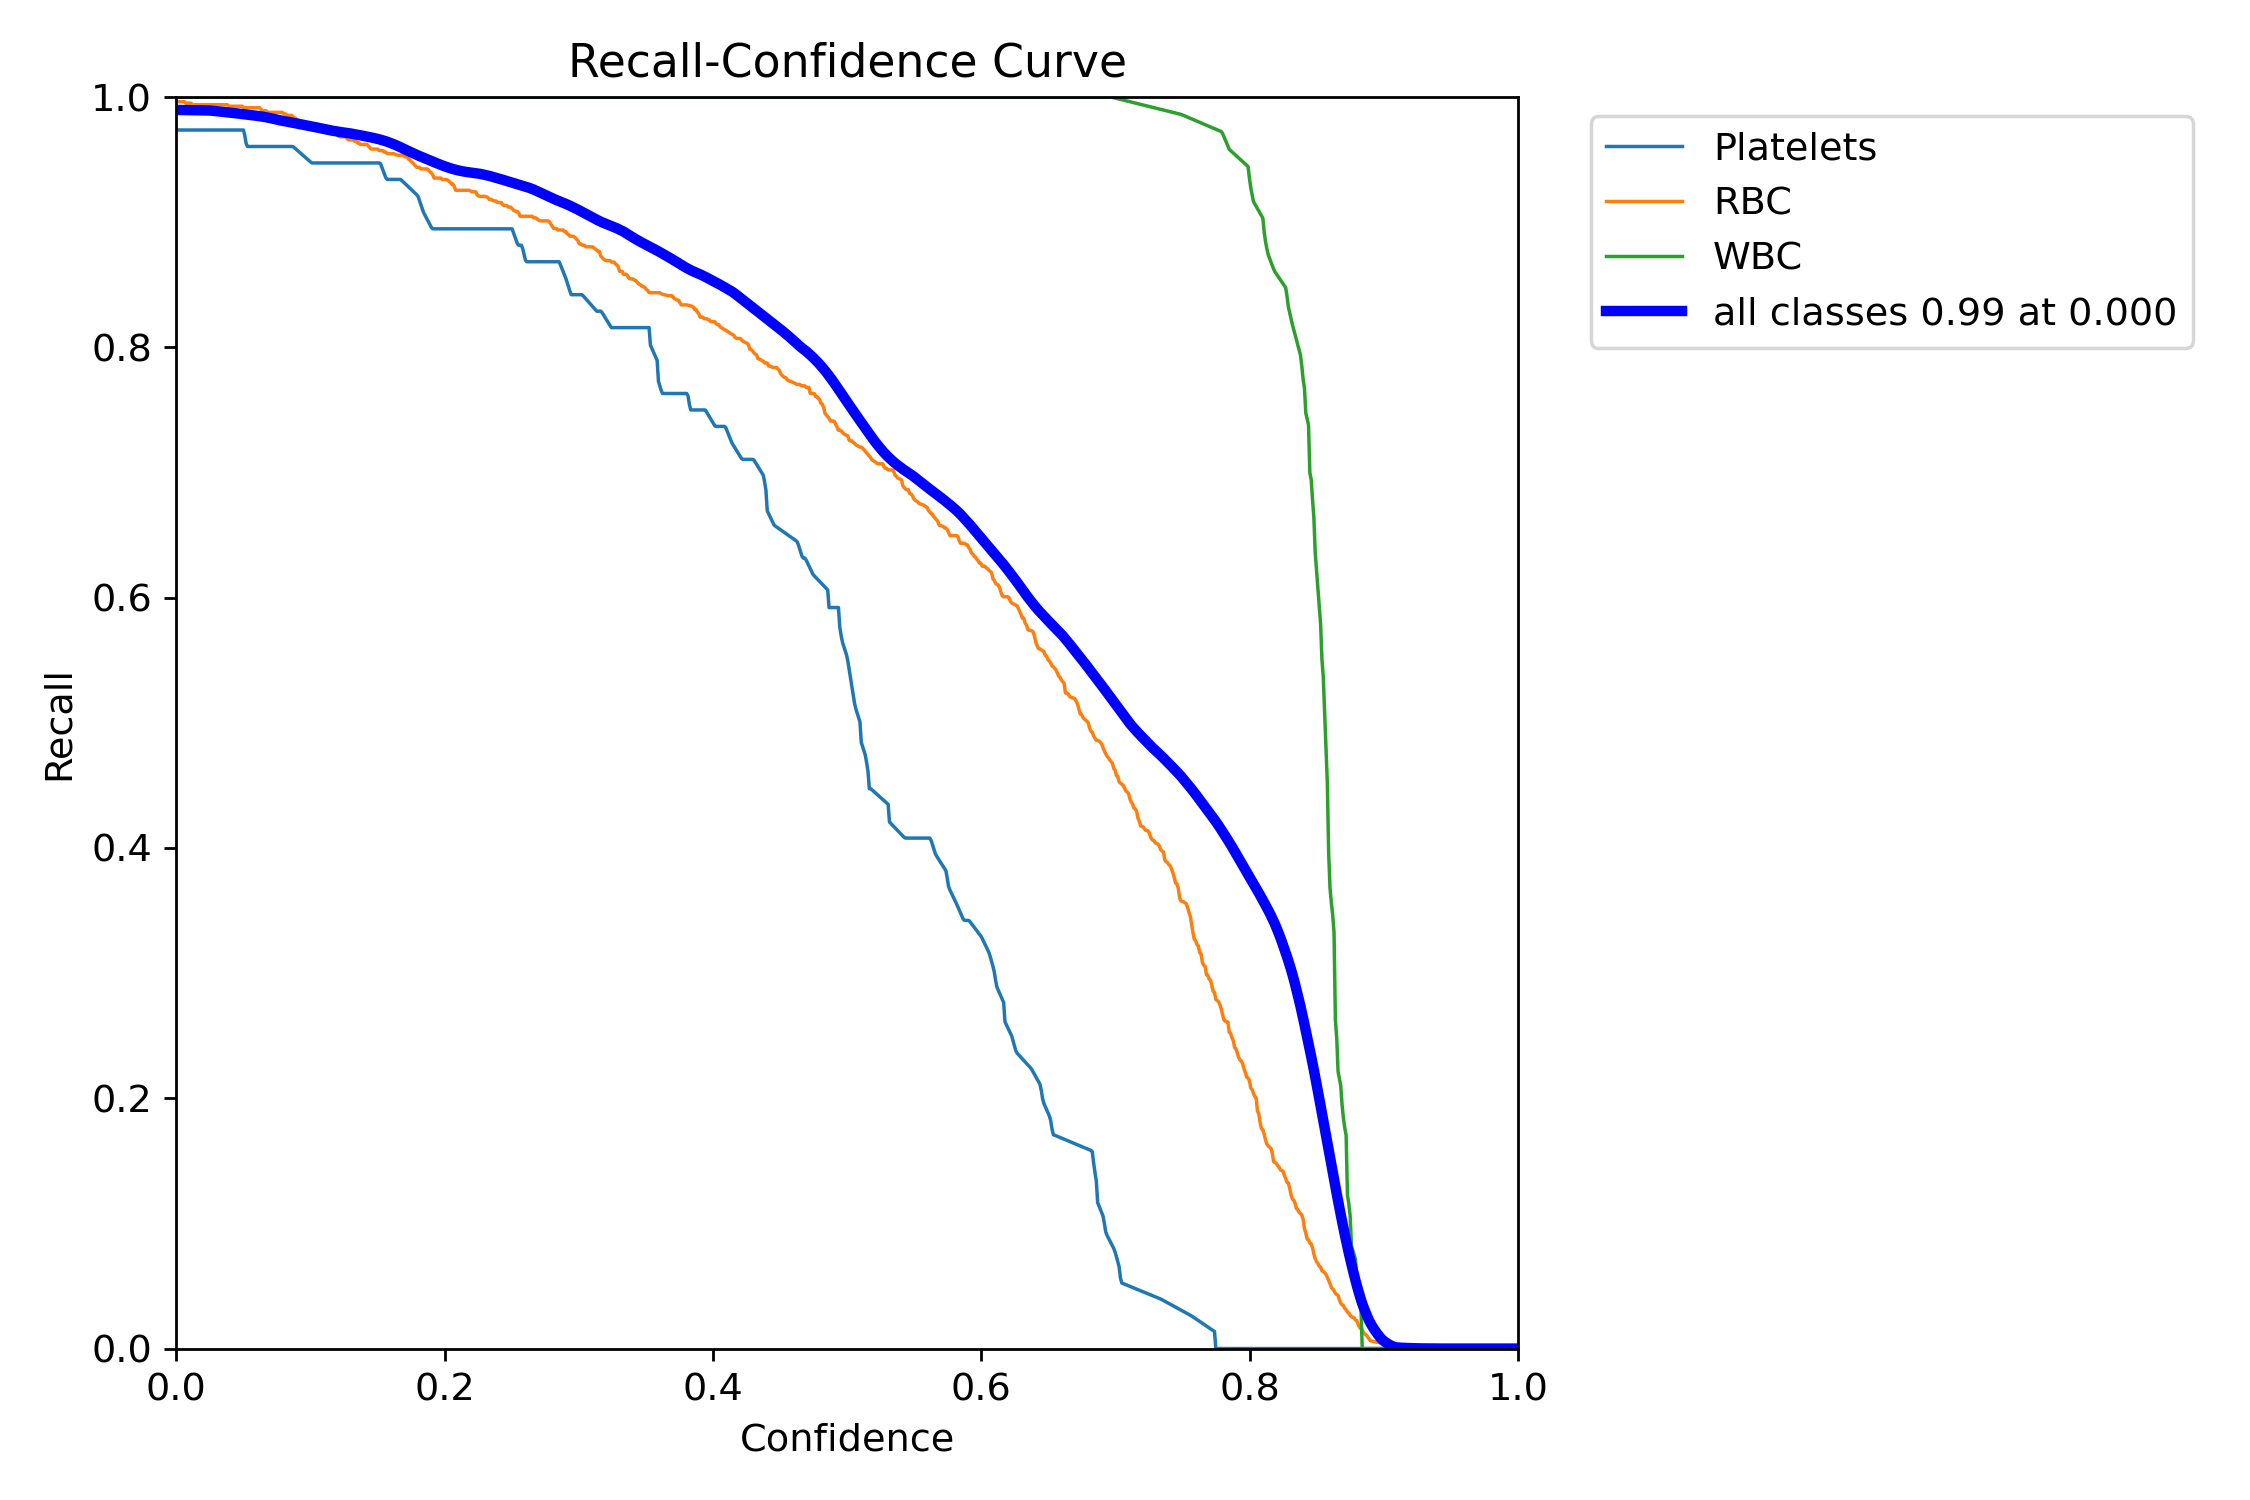

In [ ]:
Image(filename='/content/runs/detect/train/R_curve.png', height=400)

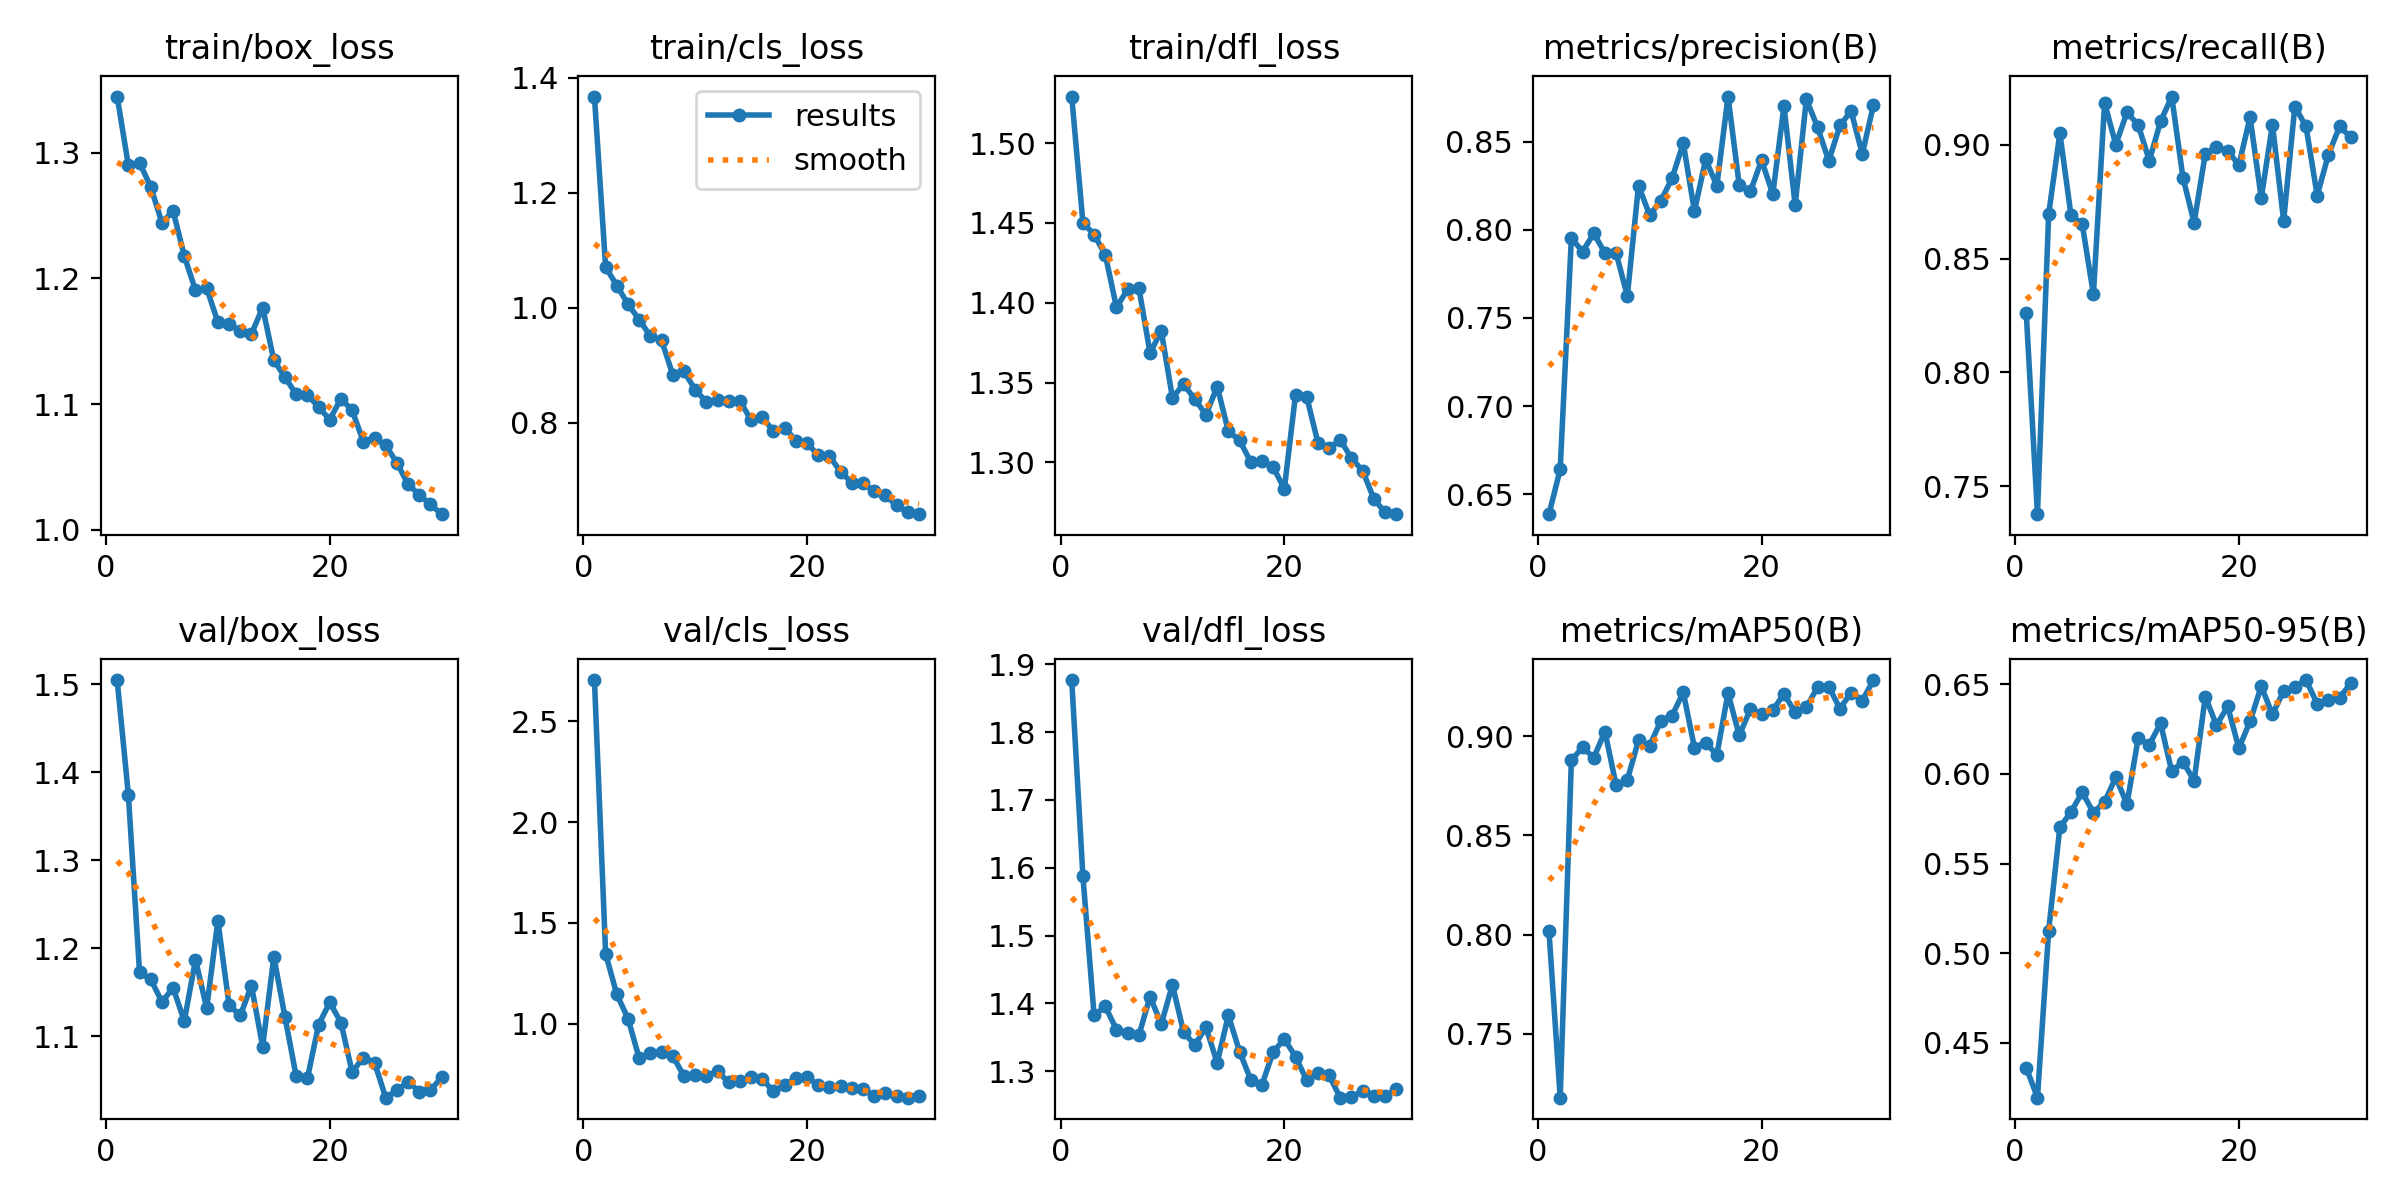

In [ ]:
Image(filename='/content/runs/detect/train/results.png', height=500)

In [ ]:
import pandas as pd

csv_path = '/content/runs/detect/train2/results.csv'
df = pd.read_csv(csv_path)
val_cls_loss = df.iloc[:, 8]
val_cls_loss

0     1.4768
1     1.2123
2     1.1504
3     1.2066
4     1.1549
5     1.2471
6     1.1008
7     1.1837
8     1.1071
9     1.1507
10    1.1433
11    1.1133
12    1.1125
13    1.1345
14    1.1318
15    1.0774
16    1.0792
17    1.0548
18    1.0771
19    1.0984
20    1.0788
21    1.1001
22    1.0698
23    1.0449
24    1.0718
25    1.0468
26    1.0414
27    1.0360
28    1.0413
29    1.0410
Name:            val/box_loss, dtype: float64

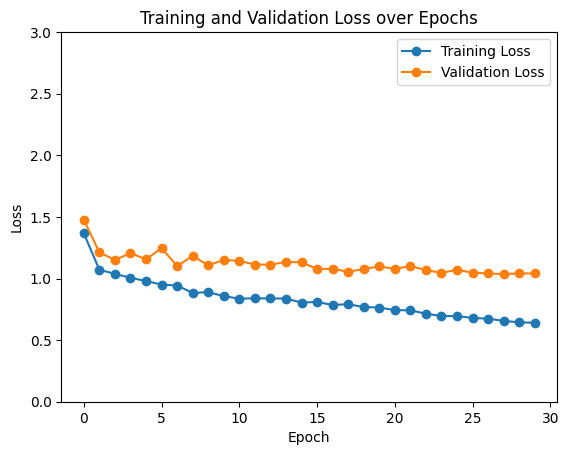

In [ ]:
import matplotlib.pyplot as plt

train_loss = [1.367, 1.071, 1.038, 1.006, 0.9794, 0.9505, 0.9433, 0.8833, 0.8891, 0.8573,
              0.8362, 0.8395, 0.838, 0.8378, 0.8046, 0.8099, 0.7852, 0.7916, 0.7684, 0.7646,
              0.7433, 0.742, 0.7145, 0.6958, 0.6945, 0.6805, 0.6735, 0.6563, 0.6442, 0.6409]
val_loss = [1.4768, 1.2123, 1.1504, 1.2066, 1.1549, 1.2471, 1.1008, 1.1837, 1.1071, 1.1507,
            1.1433, 1.1133, 1.1125, 1.1345, 1.1318, 1.0774, 1.0792, 1.0548, 1.0771, 1.0984,
            1.0788, 1.1001, 1.0698, 1.0449, 1.0718, 1.0468, 1.0414, 1.0360, 1.0413, 1.0410]

plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()